In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/nlu/master/scripts/colab_setup.sh -O - | bash

In [ ]:
import nlu
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils import initialise_logger

from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity 

In [ ]:
inputs = pd.read_csv("dummy_data.csv")
data = pd.read_csv("output/stripped_names_2021-04-23.txt", header=None).rename(columns={0: "cleaned_data"})

In [6]:
class Comparison():

    def __init__(self, database="output/stripped_names_2021-04-23.txt"):
        self.logger = initialise_logger()
        self.logger.info("loading in database")
        self.to_compare = pd.read_csv(database, header=None).rename(columns={0: "cleaned_data"})
        self.logger.info("Loading in the bert goodness")
        self.pipe = nlu.load("embed_sentence.bert")
        self.logger.info("making predictions")
        self.model = self.pipe.predict(data["cleaned_data"], output_level="document")
        self.col = self.model.columns[0]
        embed_mat = [x for x in self.model[self.col]]
        self.embed_mat = [item[0] for item in embed_mat]
        self.logger.info("Class initialised :)")
        
    def create_list_from_df(self, df):
        """If a dataframe is passed, turn it into a list."""
        tmp = []
        for col in df.columns.tolist():
            self.logger.info("Appending {}".format(col))
            tmp.extend(df[col].tolist())
        self.list_input = [x for x in tmp if str(x) != "nan"]
        return self
    
    def plot_threats(self, threshold=0.9):
        """Plot all of the threats that are more similar than a threshold."""
        self.logger.info("Reducing the columns by threshold {}".format(threshold))
        score_red = self.scores_list.apply(lambda x: np.where(x <= threshold, np.nan, x))
        # Drops all columns & rows where no entries meet the threshold
        score_red = score_red.dropna(axis=1, how="all")
        score_red = score_red.dropna(axis=0, how="all")
        
        self.logger.info("Creating plot")
        self.logger.info("The plot currently has shape {} - a low threshold will create a large plot which will be difficult to read.".format(score_red.shape))
        fig = plt.figure(figsize=(30,30))
        self.plot = sns.heatmap(score_red)
        return self.plot, score_red        
        
    def score(self, to_score):
        """Score a sentence or list of sentences against the data."""
        # Make our embedding with BERT
        embed_df = self.pipe.predict(to_score)
        embedding = embed_df.iloc[0][self.col]
        item = embed_df.iloc[0]["document_results"]

        df_out = pd.DataFrame(index=data["cleaned_data"]).astype("object")

        # Make the embedding of the input the same shape as the db
        m = embedding*len(data)   

        # Calculates the cosine similarity - results in a nested array so take first
        sim = cosine_similarity(m, self.embed_mat)[0]

        # Append a column to our output df
        df_out[embed_df.iloc[0]["document_results"]] = sim
        return df_out
    
    
    def score_list(self, to_score):
        """Score a sentence or list of sentences against the data."""    
        # Checks if you've passed a dataframe - if you have, turns it into a list  
        if isinstance(to_score, pd.DataFrame):
            self.logger.info("You've passed a dataframe - cleaning.")
            self.create_list_from_df(to_score)
            to_score = self.list_input
        self.logger.info("Predicting on given string list")
        embedding = self.pipe.predict(to_score)

        # Create the skeleton of the output dataframe
        df_out = pd.DataFrame(index=self.to_compare["cleaned_data"]).astype("object")

        self.logger.info("Calculating cosine similarities across given data, against db")
        # Calculate the cosine similarity of each inputted sentence with the entire db
        for i in tqdm(range(len(to_score))):
            tmp = self.score(to_score[i])
            df_out = df_out.join(tmp)
        
        # Saves the list to the class for later
        self.scores_list = df_out
        self.logger.info("Done")
        return df_out

In [7]:
# Initialise class, pointing to data to compare with the db
cl1 = Comparison(database="../input/to-compare/stripped_names_2021-04-23.txt")

2021-04-27 18:51:47,904 - name_strip - INFO - loading in database
2021-04-27 18:51:47,929 - name_strip - INFO - Loading in the bert goodness


sent_small_bert_L2_128 download started this may take some time.
Approximate size to download 16.1 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]

2021-04-27 18:52:16,296 - name_strip - INFO - making predictions


2021-04-27 18:53:13,559 - name_strip - INFO - Class initialised :)


In [8]:
# score the entire list of the dummy data
scores = cl1.score_list(inputs)

2021-04-27 18:53:13,567 - name_strip - INFO - You've passed a dataframe - cleaning.
2021-04-27 18:53:13,569 - name_strip - INFO - Appending Person Name
2021-04-27 18:53:13,571 - name_strip - INFO - Appending Company Name
2021-04-27 18:53:13,573 - name_strip - INFO - Predicting on given string list
2021-04-27 18:53:15,838 - name_strip - INFO - Calculating cosine similarities across given data, against db
100%|██████████| 587/587 [04:19<00:00,  2.26it/s]
2021-04-27 18:57:35,082 - name_strip - INFO - Done


2021-04-27 18:57:57,099 - name_strip - INFO - Reducing the columns by threshold 0.95
2021-04-27 18:57:57,640 - name_strip - INFO - Creating plot
2021-04-27 18:57:57,642 - name_strip - INFO - The plot currently has shape (30, 38) - a low threshold will create a large                plot which will be difficult to read.


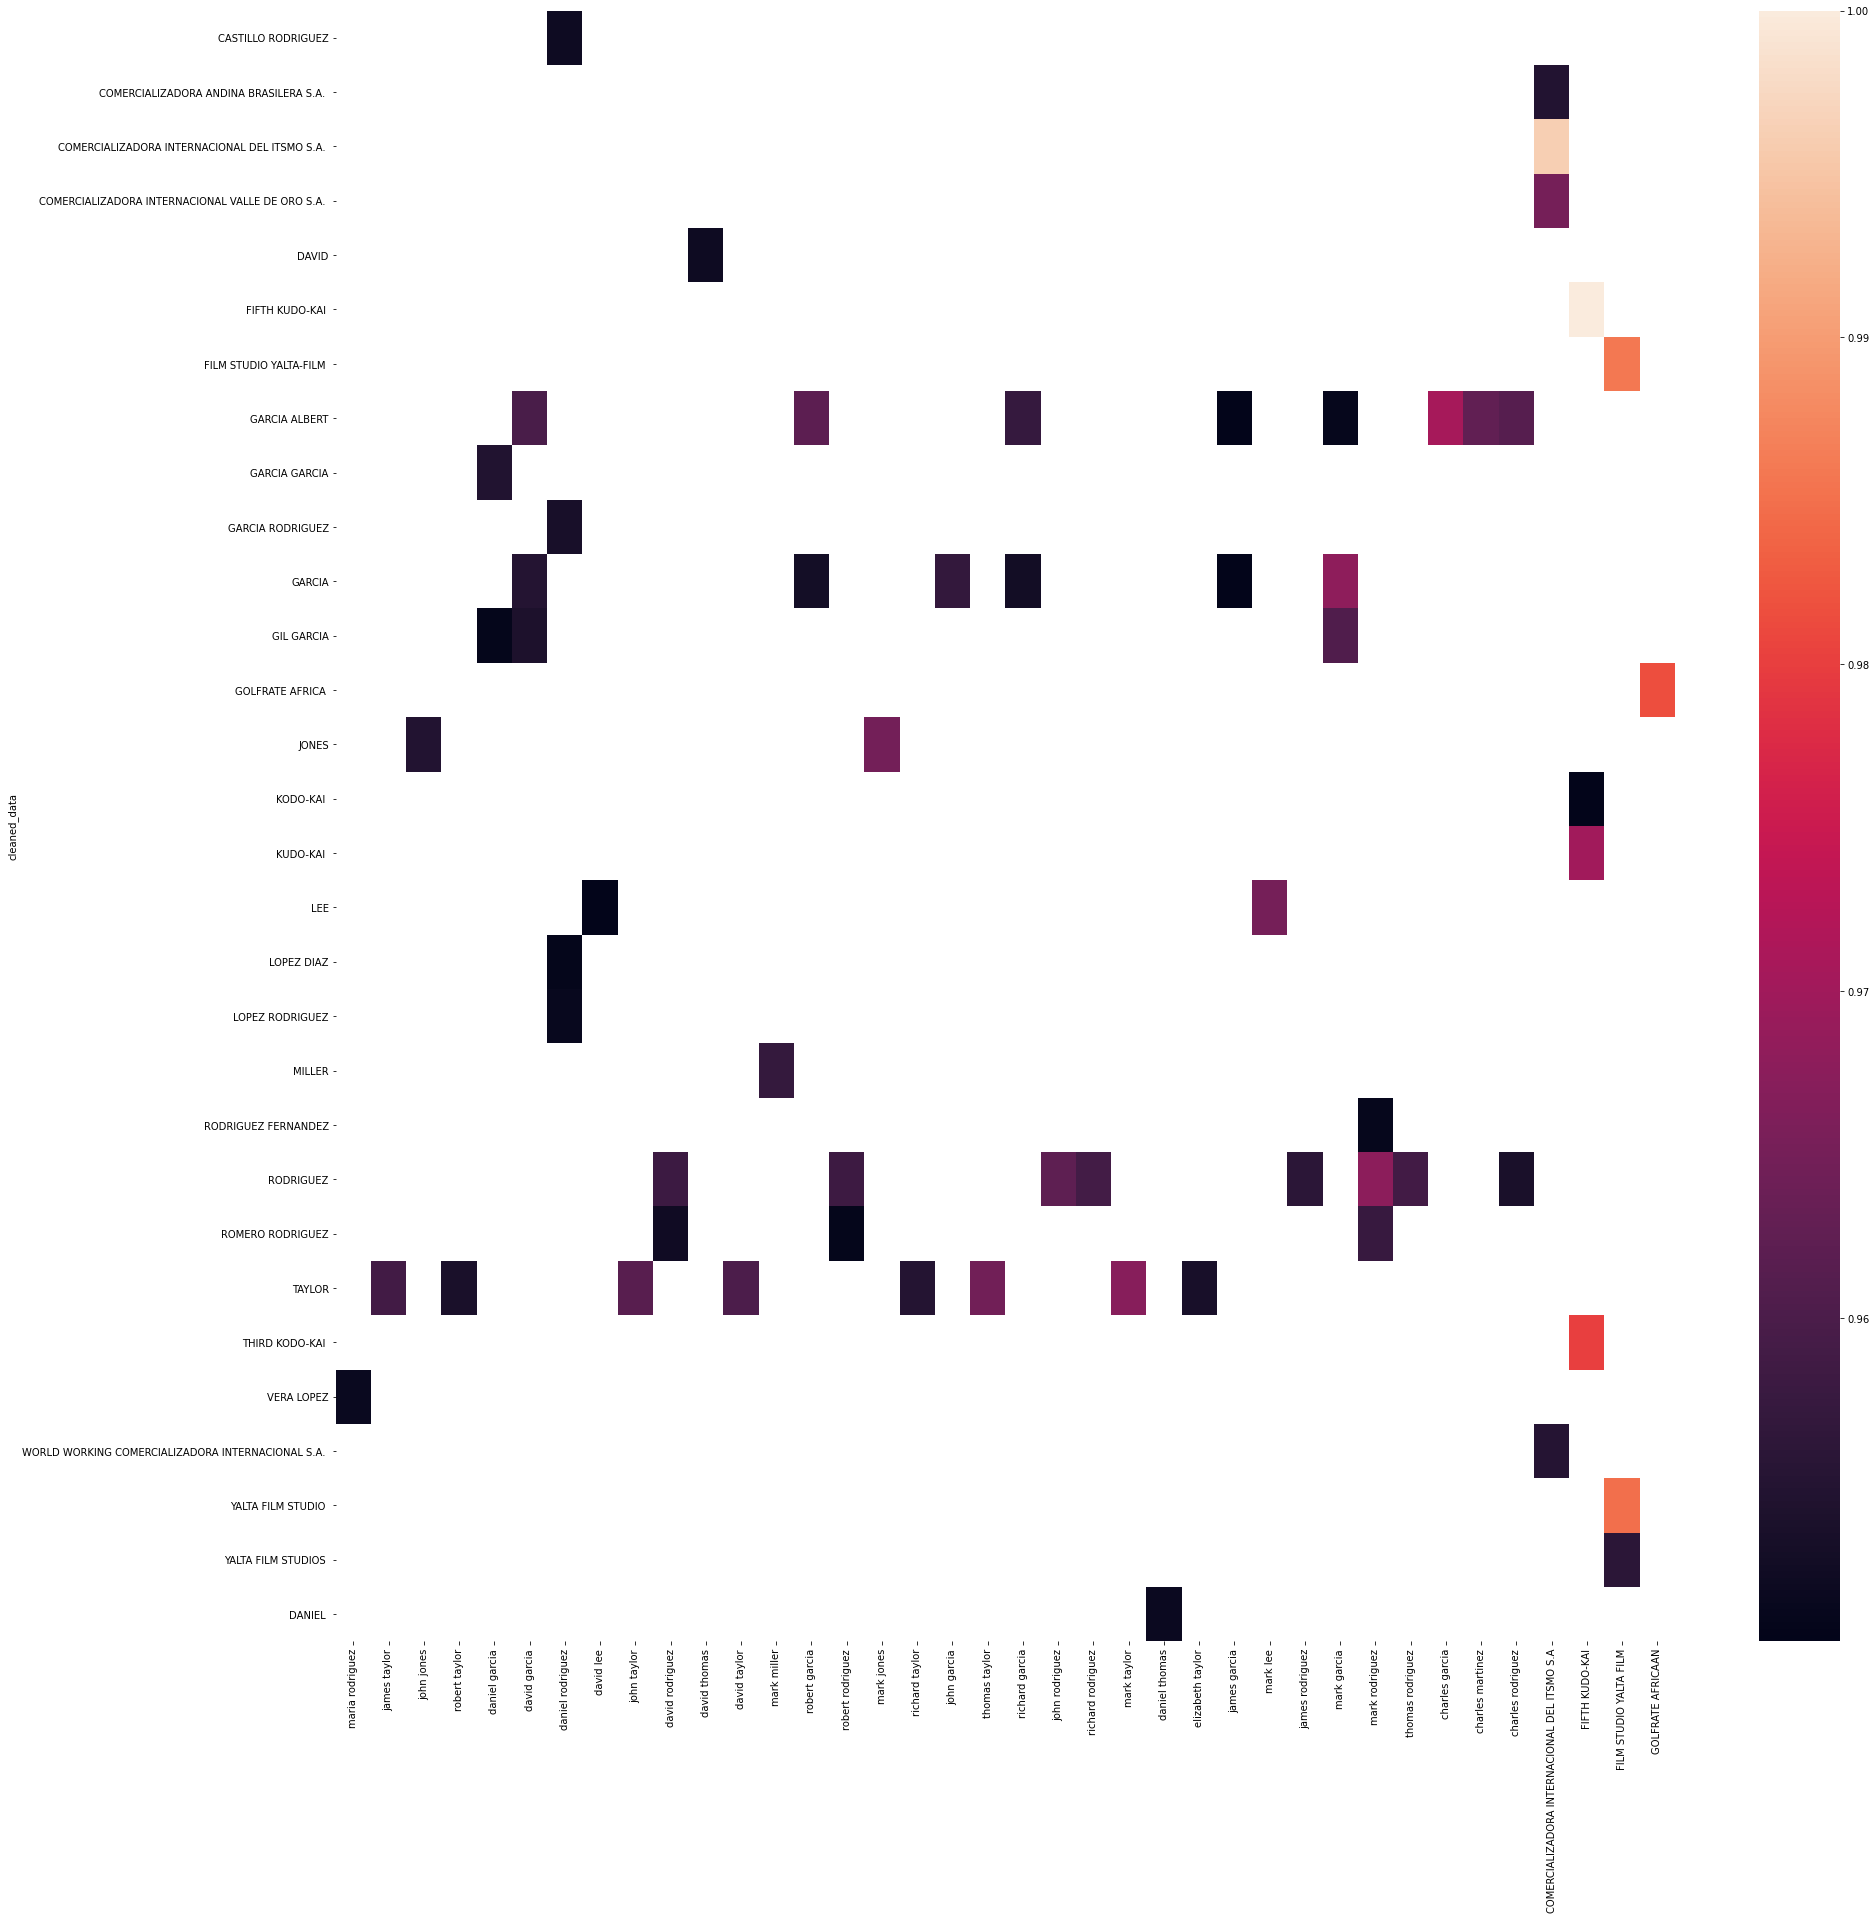

In [11]:
# Produce our output - produces a seaborn plot and a table of the outputs
plot, tab = cl1.plot_threats(threshold=0.95)

--------------